In [199]:
import numpy as np
import imageio
from matplotlib import pyplot as plt
import math

In [200]:
class OutputBitstream:
    def __init__(self, filename):
        self.filename = filename
       
    def __enter__(self):
        self.word = 0
        self.word_bits = 0
        self.file = open(self.filename, "wb")
        return self
       
    def write(self, value, length):
        assert isinstance(value, int), "value must be integer"
        assert isinstance(length, int), "length must be integer"
        assert value >= 0, "value must be non negative"
        assert value < 2 ** length, "value must be smaller than 2 ** length"
       
        self.word <<= length
        self.word |= value
        self.word_bits += length
   
        if self.word_bits >= 64:
            remaining = self.word_bits - 64
            self.file.write((self.word >> remaining).to_bytes(8, byteorder="big", signed=False))
            self.word &= (1 << remaining) - 1
            self.word_bits = remaining
   
    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.word_bits != 0:
            self.write(0, 64 - self.word_bits)
           
        self.file.close()

In [201]:
class InputBitstream:
    def __init__(self, filename):
        self.filename = filename
       
    def __enter__(self):
        self.word = 0
        self.word_bits = 0
        self.file = open(self.filename, "rb")
        return self
       
    def read(self, length):
        assert length < 8 * 32, "length is too large"
       
        if length > self.word_bits:
            value = self.file.read(32)
            self.word <<= len(value) * 8
            self.word_bits += len(value) * 8
            self.word |= int.from_bytes(value, byteorder="big", signed=False)
           
        if length > self.word_bits:
            raise "Unexpected end of file"
               
        result = self.word >> (self.word_bits - length)
        self.word_bits -= length
        self.word &= (1 << self.word_bits) - 1
       
        return result
   
    def __exit__(self, exc_type, exc_val, exc_tb):    
        self.file.close()

22


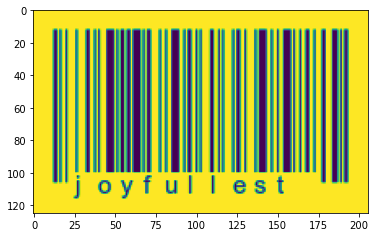

In [202]:
img = imageio.imread("sample-000039.png")
plt.imshow(img) #im

primeraLinea = 0
segonaLinea = 0
ultimaRepetida = 0
margeInferior = 0

for fila in range(img.shape[0]):
    for columna in range(img.shape[1]):
        if img[fila][columna] != 255:
            if primeraLinea == 0:
                primeraLinea = fila
                segonaLinea = fila+1


segonaLinea = img[segonaLinea]

for x in range(primeraLinea+1, img.shape[0]):
    
    if False in (img[x] == segonaLinea):
        if ultimaRepetida == 0:
            ultimaRepetida = x


for i in range(img.shape[0]):
    if img[i][12] != 255:
        margeInferior = i


            
#Left Margin
leftMargin = 0

'''
for i in range(len(img[ultimaRepetida])):
    if img[ultimaRepetida-1][i] != img[ultimaRepetida][i]:
        if leftMargin ==0:
            leftMargin = i
'''

a = len(img[ultimaRepetida+1])
a = a/2

for i in range(int(a)):
    if img[ultimaRepetida+1][i] != 255:
        leftMargin = i
    

leftMargin += 1
#Right Margin
rightMargin = 0
anterior = 0

#for i in reversed(range(len(img[ultimaRepetida]))):
for i in reversed(range(img.shape[1])):
    if img[ultimaRepetida-1][i] != img[ultimaRepetida][i]:
        if rightMargin ==0:
            rightMargin = anterior
    anterior = i
            


#print(margeInferior)
print(leftMargin)
#print(rightMargin)
#print('---------')
#print(primeraLinea)
#print(segonaLinea)
#print("La fila es repeteix fins la fila", ultimaRepetida)


In [203]:
#print(leftMargin)

In [204]:
#Fins ara tenim una funcio que retorna la ultima fila que es repeteix dins del barcode
# codeBook = primeraLinia + SegonaLinia + totes les linies que no es repeteixen
# a cada linia li podem dir codeword
# per ara hardcodegem les mesures, ja les enviarem

#codeBook =[]
#codeBook.append(img[primeraLinea])
#codeBook.append(segonaLinea)

#wordImage = []

#for i in range(ultimaRepetida, img.shape[0]):
#    for value in img[i]:   
#        wordImage.append(value)
#    codeBook.append(img[i])
#wordImageNP = np.array(wordImage)
#wordImageNP.resize(img.shape[1],img.shape[0]-ultimaRepetida)

#print("Generat Codebook")


In [205]:
def getMSE(img1, img2):  # MSE of 2 images
    return (np.sum(np.square(img1 - img2))) / img1.size


In [206]:
#Obtenir la primera a partir de la segona --> mitja del valor i color blanc(255)

def getFirstLine(common):
    computedPrimera = []

    for el in common:
        newVal = (el+255)//2
        if newVal> (el+(255//2)+0.5):
            newVal+=1
        computedPrimera.append(newVal)
    
    return computedPrimera




In [207]:
shape_x = img.shape[1]
shape_y = img.shape[0]

print(shape_x, shape_y)

test1 = np.asarray(img[13]) #common row
test1 = test1.tolist()


#remove first and last 12 255
test = test1[12:-12]

#print(test)


#write
with open('test222.bin', "wb+") as f:
    
    #header
    f.write(shape_y.to_bytes(2, byteorder="big", signed=False))
    f.write(shape_x.to_bytes(2, byteorder="big", signed=False))
    
    
    for i in range(len(test)):
        f.write(test[i].to_bytes(2, byteorder="big", signed=False))
    
    for i in range(12, leftMargin):
        f.write(int(img[margeInferior][i]).to_bytes(2, byteorder="big", signed=False))
    
    for i in range(rightMargin, shape_x):
        f.write(int(img[margeInferior][i]).to_bytes(2, byteorder="big", signed=False))
            
            
#read 
commonLine =[]

with open('test222.bin', "rb") as f:
    testReconstructed = []
    read = f.read()
    i=0
    cont=0
    ultimaRepetida = 100
    
    #header
    reconstructed_y = int.from_bytes(read[:2], byteorder="big")
    reconstructed_x = int.from_bytes(read[2:4], byteorder="big")
    
    
    ultimaLinea = [255 for i in range(reconstructed_x)]
    
        
    read = read[4:]
    
    
    for j in range(len(test)):
    
        commonLine.append(int.from_bytes(read[i:i+2], byteorder="big"))
        i+=2
    
    
    #ultima linea
    for j in range(12, leftMargin):
        ultimaLinea[j] = int.from_bytes(read[i:i+2], byteorder="big")
        i+=2
        
    
    for j in range(rightMargin, shape_x):
        ultimaLinea[j] = int.from_bytes(read[i:i+2], byteorder="big")
        i+=2


#reconstruir

#12 first 255
finalReconstructed = [255 for x in range(12)]

#12 last 255
for i in range(12):
    commonLine.append(255)

    
finalReconstructed += commonLine


#print(finalReconstructed)

primera = getFirstLine(finalReconstructed)
#ultima = getLastLine(finalReconstructed)
ultima = ultimaLinea

img_reconstructed = np.array([[255 for x in range(shape_x)] for j in range(shape_y)])

#asignem la primera fila
img_reconstructed[12] = primera
img_reconstructed[13:ultimaRepetida] = finalReconstructed



#laterals:

#LEFT
for i in range(ultimaRepetida, margeInferior):
    for j in range(leftMargin):
        img_reconstructed[i][j] = finalReconstructed[j]

#RIGHT
for i in range(ultimaRepetida, margeInferior):
    for j in reversed(range(rightMargin, reconstructed_x)):
        img_reconstructed[i][j] = finalReconstructed[j]

        
#Last Line
for j in range(12, leftMargin):
    img_reconstructed[margeInferior][j] = ultimaLinea[j]

for j in reversed(range(rightMargin, reconstructed_x-12)):
    img_reconstructed[margeInferior][j] = ultimaLinea[j]



206 125


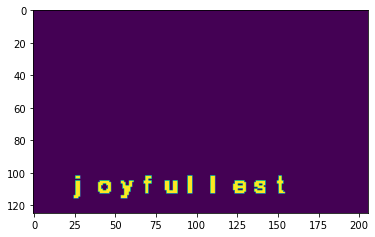

In [208]:
right = np.array([[255 for x in range(shape_x)] for j in range(shape_y)])

for i in range(shape_y):
    for j in range(shape_x):
        if img[i][j] == img_reconstructed[i][j]:
            right[i][j] = 0
        
            
        
plt.imshow(np.asarray(right))        

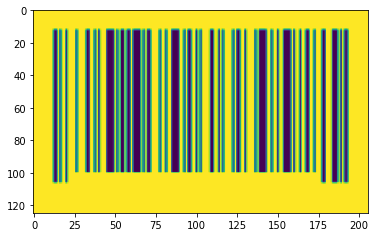

In [209]:
plt.imshow(np.asarray(img_reconstructed))

In [210]:
def rel_freq(x):
    freqs = [(value, x.count(value) / len(x)) for value in set(x)] 
    return sorted(freqs,key=lambda x:x[::-1],reverse=True)

In [211]:
print(shape_y)

125


In [212]:
print((531*8)/(shape_x*shape_y)) #calcul dels bps actuals

0.16497087378640776


In [213]:
#Codi Huffman Encoding
from collections import Counter
from itertools import chain

def count_symbols(pixels):
    values = chain.from_iterable(pixels)
    counts = Counter(values).items()
    return sorted(counts, key=lambda x:x[::-1])

def build_tree(counts) :
    nodes = [entry[::-1] for entry in counts] # Reverse each (symbol,count) tuple
    while len(nodes) > 1 :
        leastTwo = tuple(nodes[0:2]) # get the 2 to combine
        theRest = nodes[2:] # all the others
        combFreq = leastTwo[0][0] + leastTwo[1][0]  # the branch points freq
        nodes = theRest + [(combFreq, leastTwo)] # add branch point to the end
        print(nodes)
        #nodes.sort() # sort it into place
        sorted(nodes, key=lambda x:x[0])
    return nodes[0] # Return the single tree inside the list
def trim_tree(tree) :
    p = tree[1] # Ignore freq count in [0]
    if type(p) is tuple: # Node, trim left then right and recombine
        return (trim_tree(p[0]), trim_tree(p[1]))
    return p # Leaf, just return it
def assign_codes_impl(codes, node, pat):
    if type(node) == tuple:
        assign_codes_impl(codes, node[0], pat + [0]) # Branch point. Do the left branch
        assign_codes_impl(codes, node[1], pat + [1]) # then do the right branch.
    else:
        codes[node] = pat # A leaf. set its code

def assign_codes(tree):
    codes = {}
    assign_codes_impl(codes, tree, [])
    return codes
def to_binary_list(n):
    """Convert integer into a list of bits"""
    return [n] if (n <= 1) else to_binary_list(n >> 1) + [n & 1]

def from_binary_list(bits):
    """Convert list of bits into an integer"""
    result = 0
    for bit in bits:
        result = (result << 1) | bit
    return result

def pad_bits(bits, n):
    """Prefix list of bits with enough zeros to reach n digits"""
    assert(n >= len(bits))
    return ([0] * (n - len(bits)) + bits)
from PIL import Image

def compressed_size(counts, codes):
    header_size = 2 * 16 # height and width as 16 bit values

    tree_size = len(counts) * (1 + 8) # Leafs: 1 bit flag, 8 bit symbol each
    tree_size += len(counts) - 1 # Nodes: 1 bit flag each
    if tree_size % 8 > 0: # Padding to next full byte
        tree_size += 8 - (tree_size % 8)

    # Sum for each symbol of count * code length
    pixels_size = sum([count * len(codes[symbol]) for symbol, count in counts])
    if pixels_size % 8 > 0: # Padding to next full byte
        pixels_size += 8 - (pixels_size % 8)

    return (header_size + tree_size + pixels_size) / 8

def encode_header(image, bitstream):
    """
    height_bits = pad_bits(to_binary_list(image.height), 16)
    bitstream.write_bits(height_bits)    
    width_bits = pad_bits(to_binary_list(image.width), 16)
    bitstream.write_bits(width_bits)
    """
    height_bits = pad_bits(to_binary_list(image.shape[0]), 16)
    bitstream.write_bits(height_bits)    
    width_bits = pad_bits(to_binary_list(image.shape[1]), 16)
    bitstream.write_bits(width_bits)
    

def encode_tree(tree, bitstream):
    if type(tree) == tuple: # Note - write 0 and encode children
        bitstream.write_bit(0)
        encode_tree(tree[0], bitstream)
        encode_tree(tree[1], bitstream)
    else: # Leaf - write 1, followed by 8 bit symbol
        bitstream.write_bit(1)
        symbol_bits = pad_bits(to_binary_list(tree), 8)
        bitstream.write_bits(symbol_bits)

def encode_pixels(image, codes, bitstream):
    for pixel in image:
        for value in pixel:
            bitstream.write_bits(codes[value])

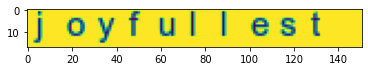

In [214]:
#Encoding process
#to start I need a np.array of the word to encode
wordBefore = np.array([[img[j][x] for x in range(leftMargin, rightMargin-1)] for j in range(ultimaRepetida+1, shape_y-7)])
plt.imshow(wordBefore)

In [215]:
counts = count_symbols(wordBefore)
print('Counts: %s' % counts)
tree = build_tree(counts)
print('Tree: %s' % str(tree))
trimmed_tree = trim_tree(tree)
print('Trimmed tree: %s' % str(trimmed_tree))
codes = assign_codes(trimmed_tree)
print('Codes: %s' % codes)

Counts: [(5, 1), (8, 1), (12, 1), (13, 1), (14, 1), (16, 1), (23, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (31, 1), (32, 1), (36, 1), (37, 1), (39, 1), (41, 1), (42, 1), (44, 1), (46, 1), (52, 1), (55, 1), (56, 1), (62, 1), (66, 1), (68, 1), (72, 1), (73, 1), (76, 1), (77, 1), (82, 1), (91, 1), (92, 1), (93, 1), (95, 1), (96, 1), (107, 1), (111, 1), (122, 1), (123, 1), (125, 1), (128, 1), (131, 1), (135, 1), (137, 1), (140, 1), (143, 1), (145, 1), (149, 1), (150, 1), (156, 1), (161, 1), (165, 1), (167, 1), (169, 1), (172, 1), (176, 1), (185, 1), (189, 1), (193, 1), (195, 1), (196, 1), (200, 1), (201, 1), (202, 1), (203, 1), (204, 1), (205, 1), (207, 1), (210, 1), (211, 1), (212, 1), (214, 1), (218, 1), (224, 1), (225, 1), (228, 1), (233, 1), (237, 1), (242, 1), (244, 1), (248, 1), (1, 2), (3, 2), (4, 2), (9, 2), (10, 2), (11, 2), (18, 2), (35, 2), (38, 2), (43, 2), (47, 2), (49, 2), (50, 2), (53, 2), (57, 2), (58, 2), (60, 2), (64, 2), (67, 2), (69, 2), (78, 2), (84, 2), (94, 2

In [216]:
size_estimate = compressed_size(counts, codes)
print(size_estimate*8)
print(((531*8)+9536)/(shape_x*shape_y)) #calcul dels bps amb huffman

19672.0
0.5353009708737864


In [217]:
shape_x = img.shape[1]
shape_y = img.shape[0]

test1 = np.asarray(img[13]) #common row
test1 = test1.tolist()


#remove first and last 12 255
test = test1[12:-12]

#print(test)


#write
with open('testuki.bin', "wb+") as f:
    
    #header 1
    f.write(shape_y.to_bytes(3, byteorder="big", signed=False))
    f.write(shape_x.to_bytes(3, byteorder="big", signed=False))
    
    
    #Content 
    for i in range(len(test)):
        f.write(test[i].to_bytes(3, byteorder="big", signed=False))
    
    for i in range(12, leftMargin):
        f.write(int(img[margeInferior][i]).to_bytes(3, byteorder="big", signed=False))
    
    for i in range(rightMargin, shape_x):
        f.write(int(img[margeInferior][i]).to_bytes(3, byteorder="big", signed=False))
    
    #Encode Tree
    #not now
    #Encode Pixels
    for pixel in wordBefore:
        for value in pixel:
            #Como por cada code son 6-7 bits, de moment guardarem 7 bits per cada
            
            f.write(from_binary_list(codes[value]).to_bytes(1, byteorder="big", signed=False))


In [218]:
print()

In [219]:
print(from_binary_list(codes[20]))

71


In [220]:
print(wordBefore.shape)
print(15*92)

(17, 151)
1380


In [221]:
def rle_encode(data):
    encoding = []
    prev_char = ''
    count = 1

    for el in data:
        if el != prev_char:

            if prev_char != '':
                encoding.append(count)
                encoding.append(prev_char)
                
            count = 1
            prev_char = el
        else:
            count += 1
    else:
        encoding.append(count)
        encoding.append(prev_char)
    return encoding


def rle_decode(data):
    reconstructed = []
    
    for i in range(len(data)):
        if i%2 == 0:
            for j in range(data[i]):
                reconstructed.append(data[i+1])
    
    
    return reconstructed

In [222]:
a = img[12]

print(len(rle_encode(a)))

print(rle_encode(a))

print(rle_decode(rle_encode(a)))

print(rle_decode(rle_encode(a)) == img[12])


264
[12, 255, 1, 203, 1, 127, 1, 139, 1, 255, 1, 171, 1, 203, 2, 255, 1, 139, 1, 235, 4, 255, 1, 171, 1, 203, 4, 255, 1, 203, 1, 127, 1, 139, 2, 255, 1, 203, 1, 171, 1, 255, 1, 139, 1, 235, 3, 255, 1, 139, 3, 127, 1, 139, 1, 255, 1, 171, 1, 203, 1, 235, 2, 127, 1, 235, 1, 203, 1, 127, 1, 139, 1, 255, 1, 171, 4, 127, 1, 235, 1, 203, 1, 171, 1, 255, 1, 139, 1, 127, 1, 203, 4, 255, 1, 203, 1, 171, 2, 255, 1, 171, 1, 203, 2, 255, 1, 139, 3, 127, 1, 139, 2, 255, 1, 203, 1, 171, 1, 255, 1, 139, 1, 127, 1, 203, 2, 255, 1, 139, 1, 235, 1, 203, 1, 171, 4, 255, 1, 235, 2, 127, 1, 235, 1, 255, 1, 235, 1, 139, 1, 255, 1, 171, 1, 203, 4, 255, 1, 203, 1, 171, 1, 255, 1, 139, 1, 127, 1, 203, 2, 255, 1, 139, 1, 235, 4, 255, 1, 171, 1, 203, 1, 235, 4, 127, 1, 171, 2, 255, 1, 171, 1, 203, 2, 255, 1, 139, 1, 235, 1, 255, 1, 235, 4, 127, 1, 171, 1, 255, 1, 139, 1, 235, 1, 255, 1, 235, 1, 139, 2, 255, 1, 203, 1, 127, 1, 139, 2, 255, 1, 203, 1, 171, 3, 255, 1, 203, 1, 127, 1, 139, 3, 255, 1, 235, 3, 127, 1,

In [223]:
#print(wordBefore)

#print(len(wordBefore[1]))
a = wordBefore.resize(len(wordBefore) * len(wordBefore[1]))





total = (rle_encode(wordBefore))

print(len(total))

print(total)


print(len(total)*8)

1034
[155, 255, 1, 251, 1, 0, 1, 179, 40, 255, 1, 211, 1, 43, 1, 7, 1, 115, 22, 255, 1, 243, 1, 0, 1, 183, 11, 255, 1, 243, 1, 0, 1, 183, 39, 255, 1, 222, 1, 176, 24, 255, 1, 253, 1, 119, 1, 215, 40, 255, 1, 92, 1, 39, 1, 189, 1, 221, 22, 255, 1, 243, 1, 0, 1, 183, 11, 255, 1, 243, 1, 0, 1, 183, 39, 255, 1, 60, 1, 115, 67, 255, 1, 76, 1, 98, 24, 255, 1, 243, 1, 0, 1, 183, 11, 255, 1, 243, 1, 0, 1, 183, 39, 255, 1, 59, 1, 115, 24, 255, 1, 251, 1, 0, 1, 179, 12, 255, 1, 236, 1, 103, 1, 26, 1, 8, 1, 64, 1, 202, 7, 255, 1, 107, 1, 42, 3, 255, 1, 220, 1, 0, 1, 208, 6, 255, 1, 35, 3, 0, 1, 223, 8, 255, 1, 243, 1, 0, 1, 183, 2, 255, 1, 243, 1, 0, 1, 187, 6, 255, 1, 243, 1, 0, 1, 183, 11, 255, 1, 243, 1, 0, 1, 183, 12, 255, 1, 242, 1, 103, 1, 20, 1, 15, 1, 69, 1, 210, 7, 255, 1, 168, 1, 43, 1, 7, 1, 28, 1, 119, 1, 251, 7, 255, 1, 67, 2, 0, 1, 31, 23, 255, 1, 251, 1, 0, 1, 179, 11, 255, 1, 252, 2, 49, 1, 195, 1, 212, 1, 94, 1, 11, 1, 217, 6, 255, 1, 203, 1, 0, 1, 206, 2, 255, 1, 128, 1, 47, 7, 

In [224]:



with open('provaRun.bin', "wb+") as f:
        
    
    for j in range(len(total)):
    
        f.write(int(total[j]).to_bytes(2, byteorder="big", signed=False))

        
with open('provaRun.bin', "rb") as f:
    read = f.read()
    letters = []
    i=0
    
    for j in range(len(total)):
    
        letters.append(int.from_bytes(read[i:i+2], byteorder="big"))
        i+=2

In [225]:
letters = rle_decode(letters)
letters = np.asarray(letters)
print(letters)

[255 255 255 ... 255 255 255]


In [226]:
'''
if False in (wordBefore == letters):
    print('WROOONG')
else:
    print('GOOOD')
print(wordBefore == letters)
'''

right = (rightMargin-1) - (leftMargin)
left = (shape_y-7) - (ultimaRepetida+1)


print(right, left)

letters.resize(left, right)


print(letters)
print(letters.shape)


'''
for i in range(len(letters)):
    for i in range(len(letters[0])):
        
        print(letters[i][j] == wordBefore[i][j])
'''
#print(letters == wordBefore)

151 17
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
(17, 151)


'\nfor i in range(len(letters)):\n    for i in range(len(letters[0])):\n        \n        print(letters[i][j] == wordBefore[i][j])\n'

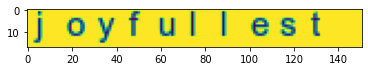

In [227]:
plt.imshow(np.asarray(letters))

In [228]:
print(img_reconstructed.shape)

(125, 206)


In [229]:
#[ultimaRepetida+1][leftMargin+1] , [shape_y-9][rightMargin-1]
'''
for i in range(ultimaRepetida+1, shape_y-9):
    for j in range(leftMargin+1, rightMargin-1):
        img_reconstructed[i][j] = letters[i-(ultimaRepetida+1)][j-(leftMargin+1)]
'''



'\nfor i in range(ultimaRepetida+1, shape_y-9):\n    for j in range(leftMargin+1, rightMargin-1):\n        img_reconstructed[i][j] = letters[i-(ultimaRepetida+1)][j-(leftMargin+1)]\n'

In [230]:


print(letters.shape)



for idxi,i in enumerate(range(ultimaRepetida+1, reconstructed_y-7)):
    for idxj,j in enumerate(range(leftMargin, rightMargin-1)):
        img_reconstructed[i][j] = letters[idxi][idxj]




(17, 151)


In [231]:
leftMargin

22

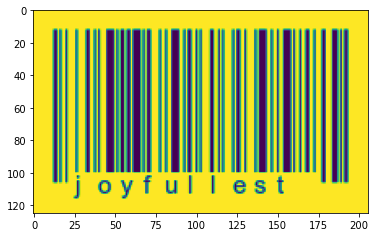

In [232]:
plt.imshow(np.asarray(img_reconstructed))

In [233]:
b = 255
c = b.to_bytes(2, byteorder="big", signed=False)

print(c)
print(int.from_bytes(c, byteorder="big", signed=False))
print("espai disponible:",954-348)
print("longitud wordBefore:", len(wordBefore))
long = 1370+348
print("longitd del bin",long)
print("bps codificats=", long*8/(shape_x*shape_y))

b'\x00\xff'
255
espai disponible: 606
longitud wordBefore: 2567
longitd del bin 1718
bps codificats= 0.533747572815534


In [234]:
mostres = (shape_x*shape_y)
print("numero de mostres:", mostres)
#motsres = samples * 1bps b/s-> bits
#mida bits/8 = bytes
print("Mida maximo amb 1bps", mostres/8 )

numero de mostres: 25750
Mida maximo amb 1bps 3218.75


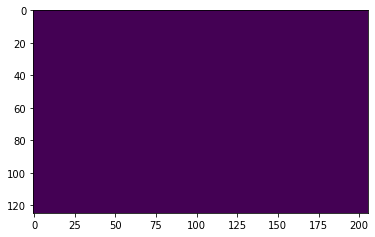

In [235]:
right = np.array([[255 for x in range(shape_x)] for j in range(shape_y)])

for i in range(shape_y):
    for j in range(shape_x):
        if img[i][j] == img_reconstructed[i][j]:
            right[i][j] = 0
        
            
        
plt.imshow(np.asarray(right))  